In [1]:
import os
import json
from os.path import join

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.stats.anova import AnovaRM

from dn_utils.misc import tidy_data
from dn_utils.plotting import plot_matrix
from dn_utils.style import BLUE, BLUE_DARK, ORANGE, ORANGE_DARK

%matplotlib inline

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [2]:
path_root = os.environ.get("DECIDENET_PATH")

path_derivatives = join(path_root, "data/main_fmri_study/derivatives")
path_sourcedata = join(path_root, "data/main_fmri_study/sourcedata") 

path_bsc = join(path_derivatives, "bsc")
path_nistats = join(path_derivatives, "nistats")
path_parcellations = join(path_derivatives, "parcellations")

path_corrmats = join(path_bsc, "corrmats")

In [3]:
atlas = "combined_roi"

# Load correlation matrices and metadata
corrmats_aggregated = np.load(join(path_corrmats, atlas, 
                                   "corrmats_aggregated.npy"))
with open(join(path_corrmats, atlas, "corrmats_aggregated.json"), "r") as f:
    meta = json.loads(f.read())
    
# Load subject exclusion
df_exclusion = pd.read_csv(join(path_nistats, "exclusion/exclusion.csv"), 
                           index_col=0)
ok_index = df_exclusion["ok_all"]   

tidy_labels = [pd.Series(meta["dim1"])[ok_index].to_list(), meta["dim2"], meta["dim3"]]

corrmats_aggregated = corrmats_aggregated[ok_index]

### Individual strenght distribution

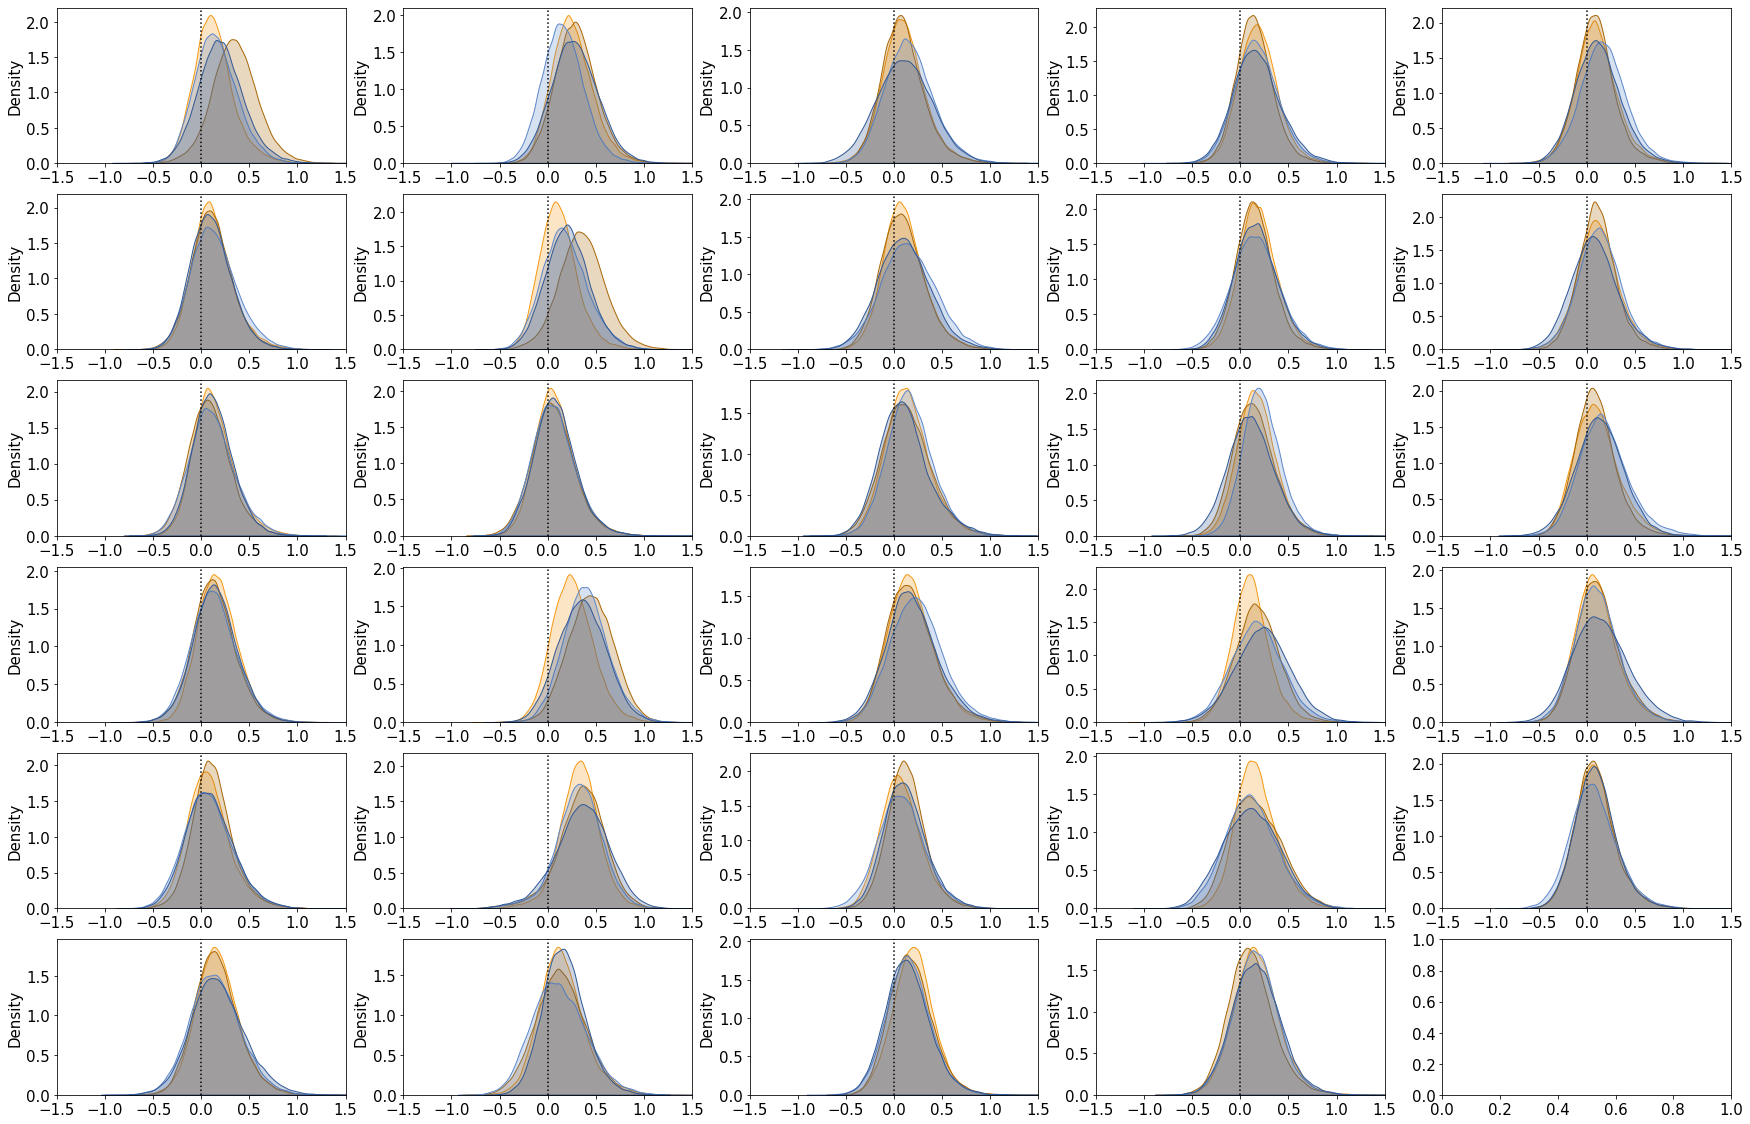

In [4]:
plt.rcParams["font.size"] = 15

fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(30, 20), facecolor="w")

for sub in range(sum(ok_index)):
    ax = axs[sub // 5][sub % 5]

    ax.set_xlim([-1.5, 1.5])
    ax.axvline(0, color="k", lineStyle=":")

    # increasing PE
    sns.kdeplot(corrmats_aggregated[sub, 0, 0].flatten(), 
                ax=ax, fill=True, color=ORANGE)
    sns.kdeplot(corrmats_aggregated[sub, 1, 0].flatten(), 
                ax=ax, fill=True, color=ORANGE_DARK)

    # decreasing PE
    sns.kdeplot(corrmats_aggregated[sub, 0, 1].flatten(), 
                ax=ax, fill=True, color=BLUE)
    sns.kdeplot(corrmats_aggregated[sub, 1, 1].flatten(), 
                ax=ax, fill=True, color=BLUE_DARK)

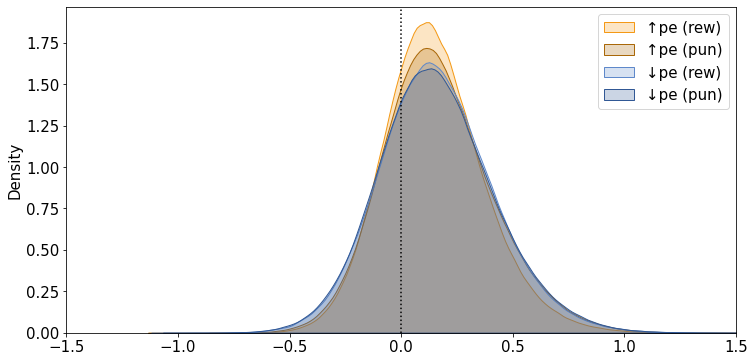

In [5]:
plt.rcParams["font.size"] = 15

fig, ax = plt.subplots(figsize=(12, 6), facecolor="w")

ax.set_xlim([-1.5, 1.5])

# increasing PE
sns.kdeplot(corrmats_aggregated[:, 0, 0].flatten(), 
            ax=ax, fill=True, color=ORANGE)
sns.kdeplot(corrmats_aggregated[:, 1, 0].flatten(), 
            ax=ax, fill=True, color=ORANGE_DARK)

# decreasing PE
sns.kdeplot(corrmats_aggregated[:, 0, 1].flatten(), 
            ax=ax, fill=True, color=BLUE)
sns.kdeplot(corrmats_aggregated[:, 1, 1].flatten(), 
            ax=ax, fill=True, color=BLUE_DARK)

plt.legend(["↑pe (rew)", "↑pe (pun)", "↓pe (rew)", "↓pe (pun)"])

ax.axvline(0, color="k", lineStyle=":")

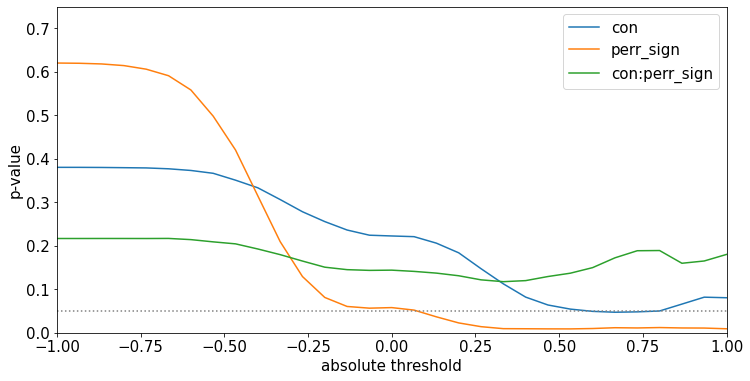

In [6]:
n_thresholds = 31

thrs = np.linspace(-1, 1, n_thresholds)

pvals = np.zeros((3, n_thresholds))
fvals = np.zeros((3, n_thresholds))

for i, thr in enumerate(thrs):

    corrmats_aggregated_thr = corrmats_aggregated * (corrmats_aggregated > thr)

    data = tidy_data(
        np.nansum(corrmats_aggregated_thr, axis=(-1, -2)), 
        depvar="depvar",
        columns=["sub", "con", "perr_sign"],
        labels=tidy_labels)
    results = AnovaRM(
        data=data, 
        depvar="depvar", 
        subject="sub", 
        within=["con", "perr_sign"]).fit()

    pvals[:, i] = results.anova_table.loc[:, "Pr > F"]
    fvals[:, i] = results.anova_table.loc[:, "F Value"]
    
# Plotting
plt.rcParams["font.size"] = 15

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(thrs, pvals.T)
ax.axhline(0.05, color="gray", lineStyle=":")

ax.set_xlim([-1, 1])
ax.set_ylim([0, 0.75])
ax.set_ylabel("p-value")
ax.set_xlabel("absolute threshold")
ax.legend(results.anova_table.index)